# Scalable GP Classification in 1D (w/ SVGP)

This example shows how to use grid interpolation based variational classification with an `AbstractVariationalGP` using a `VariationalStrategy` module while learning the inducing point locations. 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
train_x = torch.linspace(0, 1, 260)
train_y = torch.cos(train_x * (2 * math.pi)) + 0.1 * torch.randn(260)

In [7]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
class SVGPRegressionModel(AbstractVariationalGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-1))
        variational_strategy = VariationalStrategy(self,
                                                   inducing_points,
                                                   variational_distribution,
                                                   learn_inducing_locations=True)
        super(SVGPRegressionModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(0.001, 1., sigma=0.1, log_transform=True)
            )
        )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = SVGPRegressionModel(inducing_points=train_x[:25])
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [8]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.size(0), combine_terms=False)

def train():
    num_iter = 600
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        log_lik, kl_div, log_prior = mll(output, train_y)
        loss = -(log_lik - kl_div + log_prior)
        loss.backward()
        if i % 50 == 0:
            print('Iter %d - Loss: %.3f [%.3f, %.3f, %.3f]' % (i + 1, loss.item(), log_lik.item(), kl_div.item(), log_prior.item()))
        optimizer.step()
        
# Get clock time
with gpytorch.beta_features.diagonal_correction():
    %time train()

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:74: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


Iter 1 - Loss: 33.278 [-7.003, 26.274, -0.001]
Iter 51 - Loss: 7.415 [-1.319, 6.095, -0.001]
Iter 101 - Loss: 2.537 [-1.204, 1.332, -0.001]
Iter 151 - Loss: 1.339 [-1.123, 0.216, -0.001]
Iter 201 - Loss: 1.074 [-1.019, 0.053, -0.001]
Iter 251 - Loss: 0.926 [-0.878, 0.047, -0.001]
Iter 301 - Loss: 0.776 [-0.710, 0.066, -0.001]
Iter 351 - Loss: 0.589 [-0.493, 0.095, -0.001]
Iter 401 - Loss: 0.420 [-0.297, 0.122, -0.001]
Iter 451 - Loss: 0.272 [-0.143, 0.128, -0.001]
Iter 501 - Loss: 0.060 [0.046, 0.105, -0.001]
Iter 551 - Loss: -0.096 [0.237, 0.140, -0.001]
CPU times: user 36.4 s, sys: 32.5 s, total: 1min 8s
Wall time: 9.87 s


/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:74: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


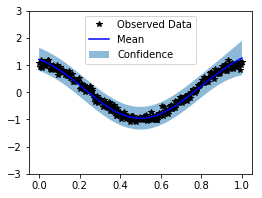

In [9]:

test_x = torch.linspace(0, 1, 51)
observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])